# ANN

The aim of this project is to implement a basic neural network from scratch.

Let's set up the project and look at our data.

## Setup

In [1]:
using Images
using Compose
using Distributions
using Gadfly

In [2]:
include("ann.jl");

In [3]:
df = dataset();

In [4]:
samples = sample(df[df[:label] .== 8, :image], 200);

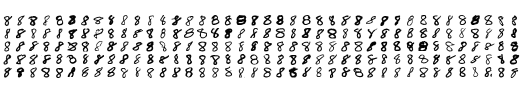

In [5]:
pngs = [to_png(256 - img) for img in samples]
draw(grid(pngs; n_cols = 40)...)

## LinearNoBias

Let's try to predict the test set for now. Will add CV next. This model simply averages the images in the trainset, grouped by class label.

In [9]:
Yp = DataFrame()
folds = cv(RandomKFolds, df)
for (k, idx_test, idx_train) in folds
    model = train(LinearNoBias, df[idx_train, :])
    predictions = prediction(model, df[idx_test, :])
    predictions[:fold] = k
    Yp = [Yp; predictions]
end

## Evaluation

Let's look at the one vs all evaluation on this training set prediction run:

In [11]:
evaluation(Yp)

,class,accuracy,precision,recall
1,0,0.966,0.764,0.944
2,1,0.975,0.881,0.902
3,2,0.962,0.934,0.666
4,3,0.95,0.753,0.766
5,4,0.96,0.872,0.695
6,5,0.945,0.948,0.418
7,6,0.971,0.828,0.896
8,7,0.971,0.959,0.749
9,8,0.914,0.536,0.867
10,9,0.94,0.656,0.825


In [12]:
describe(evaluation(Yp)[[:precision, :recall]])

precision
Min      0.536
1st Qu.  0.75575
Median   0.85
Mean     0.8131000000000002
3rd Qu.  0.9207500000000001
Max      0.959
NAs      0
NA%      0.0%

recall
Min      0.418
1st Qu.  0.7084999999999999
Median   0.7955
Mean     0.7727999999999999
3rd Qu.  0.88875
Max      0.944
NAs      0
NA%      0.0%



### Confusion matrix

The most confused digits:

In [13]:
confusions(Yp)[1:10, :]

,label,prediction,x1
1,4,9,1426
2,5,8,1127
3,5,3,1061
4,3,8,963
5,2,8,799
6,7,9,793
7,1,8,665
8,5,0,575
9,2,6,459
10,9,8,447


Overall confusion matrix:

In [14]:
confusion_matrix(Yp; n_classes = 10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
1,6518,0,11,11,6,3,133,1,206,14
2,0,7108,13,27,3,11,30,4,665,16
3,364,182,4652,244,134,0,459,75,799,81
4,196,60,113,5467,5,59,92,30,963,156
5,70,53,11,5,4743,1,192,6,317,1426
6,575,155,34,1061,106,2637,269,20,1127,329
7,270,96,70,6,38,52,6164,0,179,1
8,231,226,39,20,93,0,11,5463,417,793
9,121,114,18,326,24,16,82,8,5920,196
10,190,73,20,91,289,2,16,89,447,5741


### Confusing instances

The following numbers were misclassified:

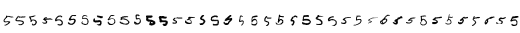

In [15]:
specimen = 5
filtered = Yp[(Yp[:label] .== specimen) & (Yp[:prediction] .!= specimen), :]
draw(grid([to_png(256 - img) for img in sample(filtered[:image], 40)]; n_cols = 40)...)

Let's have a look at the distribution over those misclassifications:

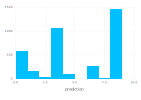

In [16]:
plot(filtered, x = :prediction, Geom.histogram)

The most common confusion is 9, then 6. This is not super surprising; we can see how those might look similar.

## Understanding the model

Let's have a look at the weights of the model. We should be able to visualize the averaged number present in each column:

In [17]:
masks = model.weights * 2^18.4 # scale up until we see something
pngs = [to_png(bound(masks[:, i])) for i in 1:10]
draw(grid(pngs; n_cols = 40)...)

LoadError: LoadError: UndefVarError: model not defined
while loading In[17], in expression starting on line 1

So in fact all we're doing is projecting new images against the prototype images we've calculated. Since both vectors have been l2 normalized to unit length, this is equivalent to the cosine distance between those vectors. We pick the one with the smallest angle (eg. the largest projection). 

Another way to view this is that we've stored image masks. Since most of the values in the weights are 0 (black), those pixels will be ignored in the source image, while the white areas will have a value if the input image has ink there. 